# **Preprocessing Pipeline**

In [18]:
!pip install librosa

In [19]:
# Imports
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import fftconvolve

import matplotlib.pyplot as plt

## **1. Synchronization of recorded audio files**

In [20]:
# Load and synchronize audio files
audio_pi1, sr1 = librosa.load("../Data/raw/output_2024-10-17_171402.158245.wav", sr=None)
print("Pi1 audio loaded.")

audio_pi2, sr2 = librosa.load("../Data/raw/Valentin2.wav", sr=None)
print("Pi2 audio loaded.")


# Load and synchronize anomalous audio files
Aaudio_pi1, sr1 = librosa.load("../Data/raw/WM_pi1_Aaudio.wav", sr=None)
print("Pi1 Aaudio loaded.")

Aaudio_pi2, sr2 = librosa.load("../Data/raw/WM_pi2_Aaudio.wav", sr=None)
print("Pi2 Aaudio loaded.")

Pi1 audio loaded.
Pi2 audio loaded.
Pi1 Aaudio loaded.
Pi2 Aaudio loaded.


In [21]:
# Ensure the sample rates match
if sr1 != sr2:
    raise ValueError("Sample rates of the two files do not match")

# Trim silence
print("Trimming silence from both audio files...")
audio_pi1, _ = librosa.effects.trim(audio_pi1)
audio_pi2, _ = librosa.effects.trim(audio_pi2)
Aaudio_pi1, _ = librosa.effects.trim(Aaudio_pi1)
Aaudio_pi2, _ = librosa.effects.trim(Aaudio_pi2)

# Synchronize normal audio files
print("Computing cross-correlation for normal recordings...")
correlation_normal = fftconvolve(audio_pi1, audio_pi2[::-1], mode='full')
lag_normal = np.argmax(correlation_normal) - len(audio_pi2)
print(f"Detected delay for normal recordings: {lag_normal / sr1} seconds")

# Align normal audio files based on the lag
print("Aligning normal audio files...")
if lag_normal > 0:
    aligned_pi1 = audio_pi1[lag_normal:]
    aligned_pi2 = audio_pi2
else:
    aligned_pi1 = audio_pi1
    aligned_pi2 = audio_pi2[-lag_normal:]

min_length_normal = min(len(aligned_pi1), len(aligned_pi2))
aligned_pi1 = aligned_pi1[:min_length_normal]
aligned_pi2 = aligned_pi2[:min_length_normal]

# Save aligned normal audio files
#sf.write("aligned_pi1.wav", aligned_pi1, sr1)
#sf.write("aligned_pi2.wav", aligned_pi2, sr1)

# Synchronize anomalous audio files
print("Computing cross-correlation for anomalous recordings...")
correlation_anomalous = fftconvolve(Aaudio_pi1, Aaudio_pi2[::-1], mode='full')
lag_anomalous = np.argmax(correlation_anomalous) - len(Aaudio_pi2)
print(f"Detected delay for anomalous recordings: {lag_anomalous / sr1} seconds")

# Align anomalous audio files based on the lag
print("Aligning anomalous audio files...")
if lag_anomalous > 0:
    aligned_Api1 = Aaudio_pi1[lag_anomalous:]
    aligned_Api2 = Aaudio_pi2
else:
    aligned_Api1 = Aaudio_pi1
    aligned_Api2 = Aaudio_pi2[-lag_anomalous:]

min_length_anomalous = min(len(aligned_Api1), len(aligned_Api2))
aligned_Api1 = aligned_Api1[:min_length_anomalous]
aligned_Api2 = aligned_Api2[:min_length_anomalous]

# Save aligned anomalous audio files
#sf.write("aligned_Api1.wav", aligned_Api1, sr1)
#sf.write("aligned_Api2.wav", aligned_Api2, sr1)

print("All processing and saving completed.")

Trimming silence from both audio files...
Computing cross-correlation for normal recordings...
Detected delay for normal recordings: -35.20156462585034 seconds
Aligning normal audio files...
Computing cross-correlation for anomalous recordings...
Detected delay for anomalous recordings: 40.390249433106575 seconds
Aligning anomalous audio files...
All processing and saving completed.


In [22]:
# Save the aligned normal audio files
print("Saving aligned normal audio files...")
sf.write("../Data/aligned/aligned_pi1.wav", aligned_pi1, sr1)
sf.write("../Data/aligned/aligned_pi2.wav", aligned_pi2, sr1)

# Save a stereo version of the aligned normal audio
combined_audio_normal = np.vstack((aligned_pi1, aligned_pi2))
sf.write("../Data/aligned/aligned_stereo_normal.wav", combined_audio_normal.T, sr1)

# Save the aligned anomalous audio files
print("Saving aligned anomalous audio files...")
sf.write("../Data/aligned/aligned_Api1.wav", aligned_Api1, sr1)
sf.write("../Data/aligned/aligned_Api2.wav", aligned_Api2, sr1)

# Save a stereo version of the aligned anomalous audio
combined_audio_anomalous = np.vstack((aligned_Api1, aligned_Api2))
sf.write("../Data/aligned/aligned_stereo_anomalous.wav", combined_audio_anomalous.T, sr1)

print("Processing and saving completed for all audio files.")

Saving aligned normal audio files...
Saving aligned anomalous audio files...
Processing and saving completed for all audio files.


## **2. Transformations (STFT & MEL)**

In [23]:
# Paths to your audio files in the aligned folder
audio_pi1_path = "../Data/aligned/WM_aligned_pi1.wav"
#audio_pi2_path = "../Data/aligned/WM_aligned_pi2.wav"
audio_Api1_path = "../Data/aligned/WM_aligned_Api1.wav"
audio_Api2_path = "../Data/aligned/WM_aligned_Api2.wav"

# Load aligned audio files
aligned_pi1, sr1 = librosa.load(audio_pi1_path, sr=None)
print("Aligned Pi1 normal audio loaded.")

aligned_pi2, sr2 = librosa.load(audio_pi1_path, sr=None)
print("Aligned Pi2 normal audio loaded.")

aligned_Api1, sr3 = librosa.load(audio_Api1_path, sr=None)
print("Aligned Pi1 anomalous audio loaded.")

aligned_Api2, sr4 = librosa.load(audio_Api2_path, sr=None)
print("Aligned Pi2 anomalous audio loaded.")


Aligned Pi1 normal audio loaded.
Aligned Pi2 normal audio loaded.
Aligned Pi1 anomalous audio loaded.
Aligned Pi2 anomalous audio loaded.


In [24]:
# Apply STFT (Short-term Fourier Transform) for all files
print("Applying Short-term Fourier Transform (STFT)...")
stft_pi1 = librosa.stft(aligned_pi1, n_fft=1024, hop_length=512)
stft_pi2 = librosa.stft(aligned_pi2, n_fft=1024, hop_length=512)
stft_Api1 = librosa.stft(aligned_Api1, n_fft=1024, hop_length=512)
stft_Api2 = librosa.stft(aligned_Api2, n_fft=1024, hop_length=512)

Applying Short-term Fourier Transform (STFT)...


In [25]:
# Convert to Mel-spectrogram
print("Converting to Mel-spectrogram...")
mel_pi1 = librosa.feature.melspectrogram(S=np.abs(stft_pi1), sr=sr1, n_mels=128)
mel_pi2 = librosa.feature.melspectrogram(S=np.abs(stft_pi2), sr=sr2, n_mels=128)
mel_Api1 = librosa.feature.melspectrogram(S=np.abs(stft_Api1), sr=sr3, n_mels=128)
mel_Api2 = librosa.feature.melspectrogram(S=np.abs(stft_Api2), sr=sr4, n_mels=128)

# Convert Mel-spectrogram to dB scale
print("Converting Mel-spectrogram to dB scale...")
mel_db_pi1 = librosa.power_to_db(mel_pi1, ref=np.max)
mel_db_pi2 = librosa.power_to_db(mel_pi2, ref=np.max)
mel_db_Api1 = librosa.power_to_db(mel_Api1, ref=np.max)
mel_db_Api2 = librosa.power_to_db(mel_Api2, ref=np.max)

# Normalize the mel-spectrograms (optional)
print("Normalizing Mel-spectrograms...")
mel_db_pi1 = (mel_db_pi1 - np.mean(mel_db_pi1)) / np.std(mel_db_pi1)
mel_db_pi2 = (mel_db_pi2 - np.mean(mel_db_pi2)) / np.std(mel_db_pi2)
mel_db_Api1 = (mel_db_Api1 - np.mean(mel_db_Api1)) / np.std(mel_db_Api1)
mel_db_Api2 = (mel_db_Api2 - np.mean(mel_db_Api2)) / np.std(mel_db_Api2)

# Save Mel-spectrograms as numpy arrays for future use
print("Saving Mel-spectrograms...")
np.save("../Data/mel/mel_db_pi1.npy", mel_db_pi1)
np.save("../Data/mel/mel_db_pi2.npy", mel_db_pi2)
np.save("../Data/mel/mel_db_Api1.npy", mel_db_Api1)
np.save("../Data/mel/mel_db_Api2.npy", mel_db_Api2)

Converting to Mel-spectrogram...
Converting Mel-spectrogram to dB scale...
Normalizing Mel-spectrograms...
Saving Mel-spectrograms...


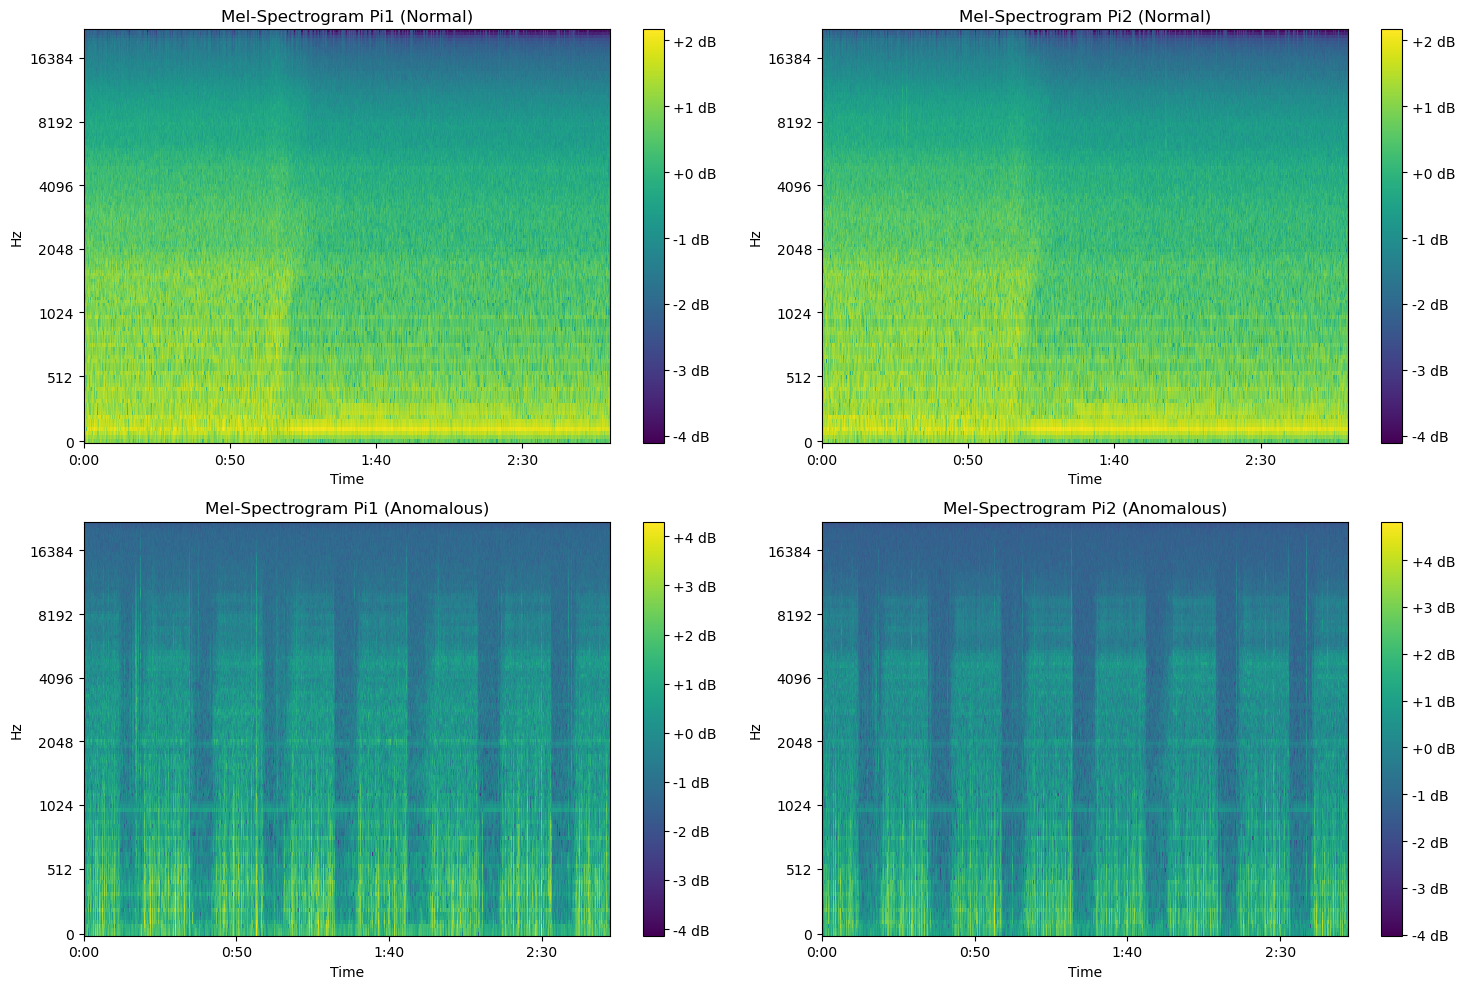

In [26]:
# Create a figure for the subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_db_pi1, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[0, 0])
axs[0, 0].set(title='Mel-Spectrogram Pi1 (Normal)')
fig.colorbar(img1, ax=axs[0, 0], format='%+2.0f dB')

# Plot Normal Pi2
img2 = librosa.display.specshow(mel_db_pi2, sr=sr2, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[0, 1])
axs[0, 1].set(title='Mel-Spectrogram Pi2 (Normal)')
fig.colorbar(img2, ax=axs[0, 1], format='%+2.0f dB')

# Plot Anomalous Pi1
img3 = librosa.display.specshow(mel_db_Api1, sr=sr3, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[1, 0])
axs[1, 0].set(title='Mel-Spectrogram Pi1 (Anomalous)')
fig.colorbar(img3, ax=axs[1, 0], format='%+2.0f dB')

# Plot Anomalous Pi2
img4 = librosa.display.specshow(mel_db_Api2, sr=sr4, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[1, 1])
axs[1, 1].set(title='Mel-Spectrogram Pi2 (Anomalous)')
fig.colorbar(img4, ax=axs[1, 1], format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrograms_comparison.png')
plt.show()

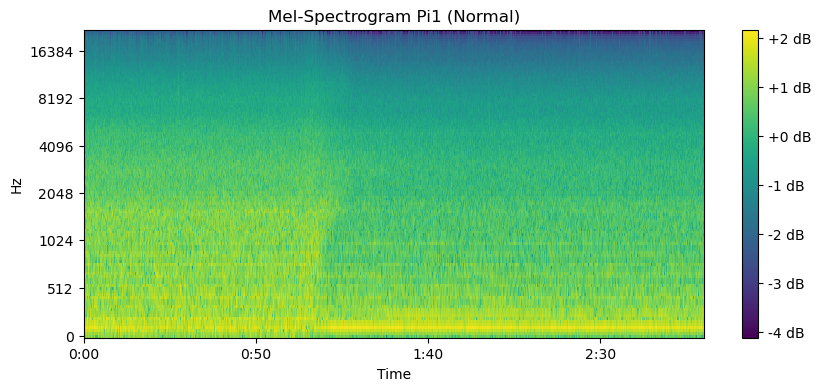

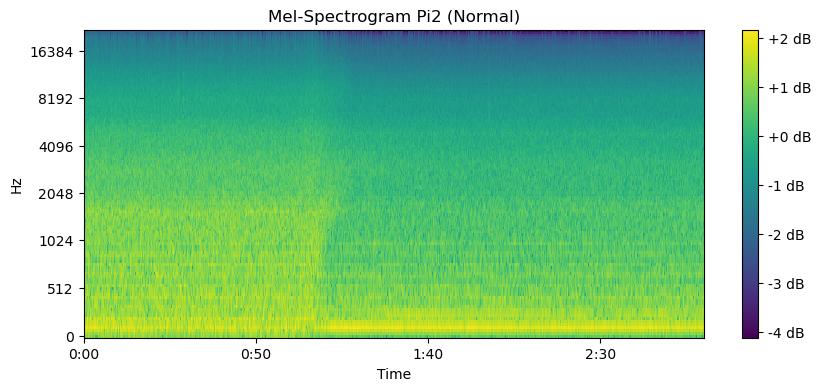

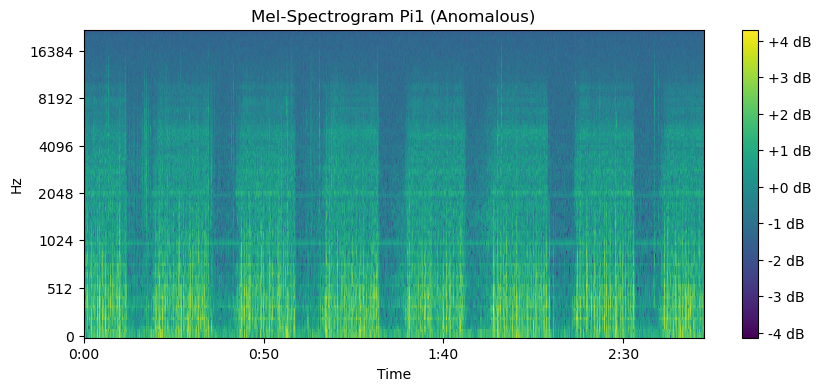

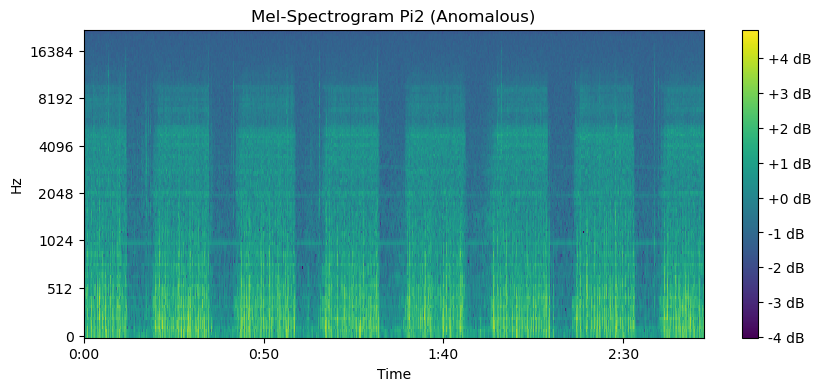

In [27]:
# Plot and save the Mel-spectrograms

# Normal Pi1
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_pi1, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Pi1 (Normal)')
plt.savefig('../Data/mel/mel_spectrogram_pi1.png')
plt.show()

# Normal Pi2
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_pi2, sr=sr2, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Pi2 (Normal)')
plt.savefig('../Data/mel/mel_spectrogram_pi2.png')
plt.show()

# Anomalous Pi1
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_Api1, sr=sr3, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Pi1 (Anomalous)')
plt.savefig('../Data/mel/mel_spectrogram_Api1.png')
plt.show()

# Anomalous Pi2
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db_Api2, sr=sr4, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Pi2 (Anomalous)')
plt.savefig('../Data/mel/mel_spectrogram_Api2.png')
plt.show()

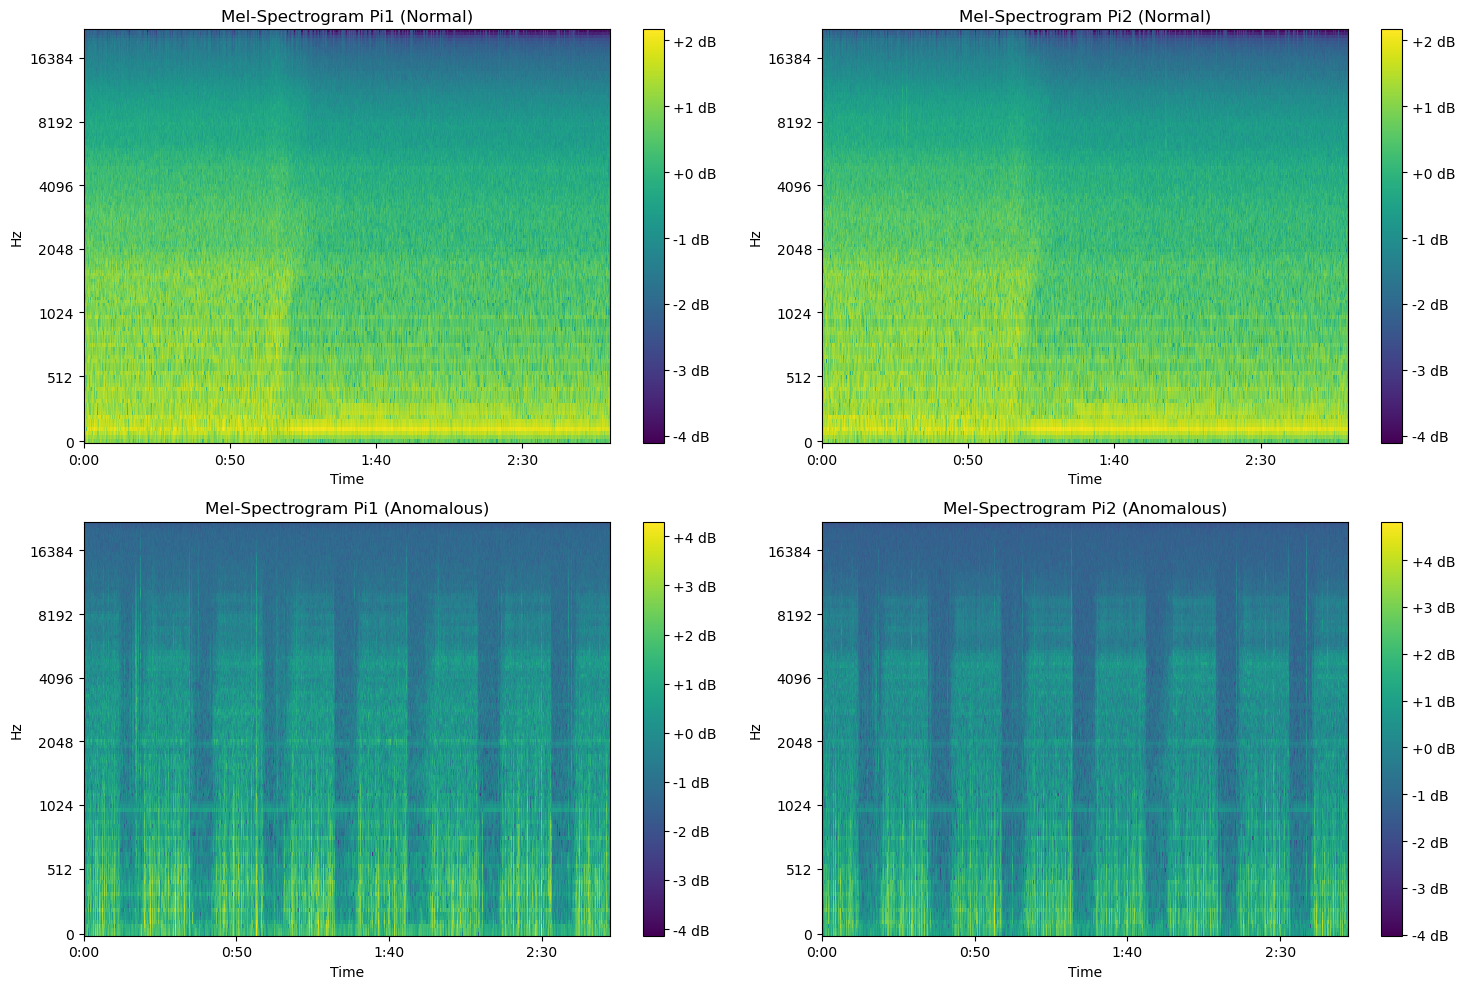

In [28]:
# Create a figure for the subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot Normal Pi1
img1 = librosa.display.specshow(mel_db_pi1, sr=sr1, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[0, 0])
axs[0, 0].set(title='Mel-Spectrogram Pi1 (Normal)')
fig.colorbar(img1, ax=axs[0, 0], format='%+2.0f dB')

# Plot Normal Pi2
img2 = librosa.display.specshow(mel_db_pi2, sr=sr2, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[0, 1])
axs[0, 1].set(title='Mel-Spectrogram Pi2 (Normal)')
fig.colorbar(img2, ax=axs[0, 1], format='%+2.0f dB')

# Plot Anomalous Pi1
img3 = librosa.display.specshow(mel_db_Api1, sr=sr3, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[1, 0])
axs[1, 0].set(title='Mel-Spectrogram Pi1 (Anomalous)')
fig.colorbar(img3, ax=axs[1, 0], format='%+2.0f dB')

# Plot Anomalous Pi2
img4 = librosa.display.specshow(mel_db_Api2, sr=sr4, x_axis='time', y_axis='mel', cmap='viridis', ax=axs[1, 1])
axs[1, 1].set(title='Mel-Spectrogram Pi2 (Anomalous)')
fig.colorbar(img4, ax=axs[1, 1], format='%+2.0f dB')

# Adjust layout
plt.tight_layout()
plt.savefig('../Data/mel/mel_spectrograms_comparison.png')
plt.show()

## **3. Frame Generation**

In [29]:
def generate_frames(mel_spectrogram, frame_size=128, hop_size=64):
    num_frames = (mel_spectrogram.shape[1] - frame_size) // hop_size + 1
    frames = np.zeros((num_frames, mel_spectrogram.shape[0], frame_size))

    for i in range(num_frames):
        start = i * hop_size
        frames[i] = mel_spectrogram[:, start:start + frame_size]

    return frames

# Generate frames for normal Pi1 and Pi2
frames_pi1 = generate_frames(mel_db_pi1)
frames_pi2 = generate_frames(mel_db_pi2)

# Generate frames for anomalous Pi1 and Pi2
frames_Api1 = generate_frames(mel_db_Api1)
frames_Api2 = generate_frames(mel_db_Api2)

print(f"Frames Pi1 (Normal): {frames_pi1.shape}")
print(f"Frames Pi2 (Normal): {frames_pi2.shape}")
print(f"Frames Api1 (Anomalous): {frames_Api1.shape}")
print(f"Frames Api2 (Anomalous): {frames_Api2.shape}")

Frames Pi1 (Normal): (241, 128, 128)
Frames Pi2 (Normal): (241, 128, 128)
Frames Api1 (Anomalous): (230, 128, 128)
Frames Api2 (Anomalous): (230, 128, 128)


In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score, roc_curve
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import librosa

# Helper function to convert complex numbers to real
def convert_complex_to_real(value):
    return complex(value).real

# Feature extraction function (assuming a simplified version for demonstration)
def get_features(filename, n_fft=2048, sr=22050, means=False):
    ''' Extracts MFCC, Log Mel energy, and Chroma (CENS) features '''
    y, sr = librosa.load(filename, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    log_mel = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft), ref=np.max)
    chroma = librosa.feature.chroma_cens(y=y, sr=sr)
    
    features = np.hstack([mfcc, log_mel, chroma])
    if means:
        features = np.mean(features, axis=1)
    
    return features

# Function to apply feature extraction on a DataFrame
def get_df_feat(df, n_fft=2048, sr=22050, means=False):
    feat_cols = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        filename = row['filename']
        feat = get_features(filename, n_fft=n_fft, sr=sr, means=means)
        feat_cols.append(feat)
    feat_df = pd.DataFrame(feat_cols)
    feat_df = feat_df.applymap(convert_complex_to_real)
    return feat_df

# **Autoencoder**

## 4.1 Architecture

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape[0] * input_shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_shape[0] * input_shape[1]),
            nn.Sigmoid(),  # Sigmoid to ensure values are in the range [0,1]
            nn.Unflatten(1, input_shape)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
input_shape = (frames_pi1.shape[1], frames_pi1.shape[2])  # Shape based on frames
autoencoder = Autoencoder(input_shape)

# Print model architecture
print(autoencoder)

ModuleNotFoundError: No module named 'torch'

## 4.2 Data preparation

In [ ]:
# Combine normal and anomalous data into training and testing sets
X_train = np.vstack([frames_pi1.reshape(len(frames_pi1), -1), frames_pi2.reshape(len(frames_pi2), -1)])
X_test = np.vstack([
    frames_pi1.reshape(len(frames_pi1), -1),
    frames_pi2.reshape(len(frames_pi2), -1),
    frames_Api1.reshape(len(frames_Api1), -1),
    frames_Api2.reshape(len(frames_Api2), -1),
])
y_test = np.array([1] * (len(frames_pi1) + len(frames_pi2)) + [-1] * (len(frames_Api1) + len(frames_Api2)))

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Split frames for Pi1
frames_pi1_train, frames_pi1_val = train_test_split(frames_pi1, test_size=0.2, random_state=42)
frames_pi2_train, frames_pi2_val = train_test_split(frames_pi2, test_size=0.2, random_state=42)

# Combine training sets from both Pi1 and Pi2
frames_train = np.concatenate((frames_pi1_train, frames_pi2_train), axis=0)
frames_val = np.concatenate((frames_pi1_val, frames_pi2_val), axis=0)

# Convert to PyTorch tensors
frames_train_tensor = torch.Tensor(frames_train)
frames_val_tensor = torch.Tensor(frames_val)

# Create DataLoaders for training and validation
train_dataset = TensorDataset(frames_train_tensor, frames_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(frames_val_tensor, frames_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 4.3 AE Training


In [ ]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training the autoencoder
epochs = 50
for epoch in range(epochs):
    autoencoder.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation phase
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_outputs = autoencoder(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()

    print(f'Epoch {epoch+1}/{epochs}, '
          f'Training Loss: {running_loss/len(train_loader):.4f}, '
          f'Validation Loss: {val_loss/len(val_loader):.4f}')

# Save the trained model
torch.save(autoencoder.state_dict(), "autoencoder_model.pth")

## 4.4 AE Evaluation

In [ ]:
# Evaluate on validation data to set a threshold for anomaly detection
autoencoder.eval()
with torch.no_grad():
    reconstructed_frames = autoencoder(frames_val_tensor)
    reconstruction_error = torch.mean(torch.abs(frames_val_tensor - reconstructed_frames), dim=(1, 2))

# Convert error to NumPy array for further processing
reconstruction_error = reconstruction_error.numpy()

# Define a threshold for anomaly detection (e.g., 95th percentile)
threshold = np.percentile(reconstruction_error, 95)
print(f"Anomaly detection threshold: {threshold}")

In [ ]:
import matplotlib.pyplot as plt

# Plot reconstruction error distribution for normal validation set
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_error, bins=50, alpha=0.6, label='Normal Validation')
plt.hist(test_reconstructed_error_Api1, bins=50, alpha=0.6, label='Anomalous Api1')
plt.hist(test_reconstructed_error_Api2, bins=50, alpha=0.6, label='Anomalous Api2')
plt.axvline(x=threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Visualize original and reconstructed frames for one anomalous frame
def plot_original_vs_reconstructed(original, reconstructed, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{title} - Original")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"{title} - Reconstructed")
    plt.colorbar()
    plt.show()

# Example: Compare one anomalous frame from Api1
with torch.no_grad():
    frame_index = 0  # Adjust this index to view different frames
    original_frame = frames_Api1_tensor[frame_index].numpy()
    reconstructed_frame = test_reconstructed_Api1[frame_index].numpy()
    plot_original_vs_reconstructed(original_frame, reconstructed_frame, "Api1 Anomalous Frame")

## 4.5 Test AE

In [ ]:
# Test on new data (Anomalous Pi1 and Pi2)
frames_Api1_tensor = torch.Tensor(frames_Api1)
frames_Api2_tensor = torch.Tensor(frames_Api2)

with torch.no_grad():
    test_reconstructed_Api1 = autoencoder(frames_Api1_tensor)
    test_reconstructed_error_Api1 = torch.mean(torch.abs(frames_Api1_tensor - test_reconstructed_Api1), dim=[1, 2])

    test_reconstructed_Api2 = autoencoder(frames_Api2_tensor)
    test_reconstructed_error_Api2 = torch.mean(torch.abs(frames_Api2_tensor - test_reconstructed_Api2), dim=[1, 2])

# Convert to NumPy
test_reconstructed_error_Api1 = test_reconstructed_error_Api1.numpy()
test_reconstructed_error_Api2 = test_reconstructed_error_Api2.numpy()

# Detect anomalies
anomalies_Api1 = test_reconstructed_error_Api1 > threshold
anomalies_Api2 = test_reconstructed_error_Api2 > threshold

print(f"Number of anomalies detected in Api1: {np.sum(anomalies_Api1)}")
print(f"Number of anomalies detected in Api2: {np.sum(anomalies_Api2)}")

## 4.6 Save Model and Results

In [ ]:
# Save the trained model
torch.save(autoencoder.state_dict(), 'trained_autoencoder.pth')

# Save reconstruction errors
np.save('reconstruction_errors_Api1.npy', test_reconstructed_error_Api1)
np.save('reconstruction_errors_Api2.npy', test_reconstructed_error_Api2)

## Next Steps:
- Treshold tuning + test data
- Real-time deplyoment: integrate model into real-time system to analyze live data